In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import itertools
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageFile
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import snntorch.spikeplot as splt


print(torch.cuda.is_available())

True


In [2]:
#data_path='/data/mnist'
data_path = '\\Users\\liamh\\OneDrive - University of Strathclyde\\University'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Training Parameters
batch_size=128

device(type='cuda')

# Simple Artificial Neural Network 

## Defining Functions

In [3]:
num_hidden = 1000
num_outputs = 10
epochs = 5

def load_in_data(res):
    transform = transforms.Compose([
    transforms.Resize((res, res)), #Resize images to 28*28
    transforms.Grayscale(), # Make sure image is grayscale
    transforms.ToTensor(), # change each image array to a tensor
    transforms.Normalize((0,), (1,))]) # normalise the tensors so they are between 0 and 1. 

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # Download training set and apply transformations. 
    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform) # same for test set
    
    train_size = int(len(mnist_train) * 0.7)
    valid_size = len(mnist_train) - train_size
    
    train_data, valid_data = torch.utils.data.random_split(mnist_train, [train_size , valid_size], generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # Load the data into the DataLoader so it's passed through the model, shuffled in batches. 
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader, valid_loader, test_loader

# Define Network
class Ann_Net(nn.Module):
    def __init__(self,res,num_hidden,num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(res*res, num_hidden)     # input layer with as many neurons as pixels. 
        self.fc2 = nn.Linear(num_hidden, num_hidden)    # Second Dense/linear layer that receives the output spikes from previous layer
        self.fc3 = nn.Linear(num_hidden, num_outputs)
    
    def forward(self,x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return(F.log_softmax(self.fc3(x),dim = 1)) # dim = 1 sums the rows so they equal 1. I.e. each input. 



loss_fn = nn.NLLLoss()  # Negative log-likelihood loss function
def train_model(train_loader, valid_loader, model, epochs ,device = device):
    
    history = defaultdict(list)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999)) # Just an Adam Optimiser
    
    # Training variables
    train_size = len(train_loader.dataset)
    train_num_batches = len(train_loader)
    
    # validation variables
    valid_size = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    
    
    for t in range(epochs):
        correct = 0
        avg_valid_loss, valid_correct = 0, 0
        
        print(f"Epoch {t+1} of {epochs}")
        print('-' * 15)
        

        for batch, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # Store loss history for future plotting
            history['train_minibatch_loss'].append(loss.item()) 

            # Backpropagation
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]") # 7f turns the number to loads of decimals, 5d moves it to the right. 

        history['train_loss'].append(loss.item())
        avg_train_loss = loss / train_num_batches
        accuracy = correct / train_size * 100           
        history['train_accuracy'].append(accuracy)
              
        print(f"Train Error:\n Accuracy: {(accuracy):>0.1f}%, Avg loss: {avg_train_loss:>8f} \n")

              ###################### VALIDATION LOOP ##############################
        with torch.no_grad():
            for valid_X, valid_y in valid_loader:
                valid_X = valid_X.to(device)
                valid_y = valid_y.to(device)

                valid_pred = model(valid_X)
                valid_loss = loss_fn(valid_pred, valid_y).item()
                avg_valid_loss += loss_fn(valid_pred, valid_y).item()
                valid_correct += (valid_pred.argmax(1) == valid_y).type(torch.float).sum().item()
              
                history['valid_minibatch_loss'].append(valid_loss)

        avg_valid_loss /= num_batches
        valid_accuracy = valid_correct / valid_size * 100
              
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f"Validation Error: \n Accuracy: {(valid_accuracy):>0.1f}%, Avg loss: {avg_valid_loss:>8f} \n")


    print("Done!")
    return history

def plot_training_history(history, ylimita = 1.05, ylimitb_lower = -0.05, ylimitb_upper = 105):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    
    ax1.plot(history['train_loss'], label='train loss',marker = 'o')
    ax1.plot(history['valid_loss'], label='validation loss',marker = 'o')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, ylimita])
    ax1.legend()
    ax1.set_ylabel('Loss',fontsize = 16)
    ax1.set_xlabel('Epoch',fontsize = 16)
    
    ax2.plot(history['train_accuracy'], label='train accuracy',marker = 'o')
    ax2.plot(history['valid_accuracy'], label='validation accuracy',marker = 'o')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([ylimitb_lower, ylimitb_upper])

    ax2.legend()

    ax2.set_ylabel('Accuracy',fontsize = 16)
    ax2.yaxis.set_major_formatter(PercentFormatter(100))
    ax2.set_xlabel('Epoch',fontsize = 16)
    fig.suptitle('Training history',fontsize = 20)
    plt.show()

def store_best_results(history):
    # Want to take the last entry from each output(best results) and store them all in a Dataframe
    placeholder = []
    placeholder.append(history['train_loss'][-1])
    placeholder.append(history['train_accuracy'][-1])
    placeholder.append(history['valid_loss'][-1])
    placeholder.append(history['valid_accuracy'][-1])
    
    return placeholder

# Creating models

## Training on 56*56

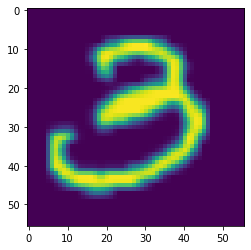

In [5]:
resolution = 56
im_36, _,_ = load_in_data(resolution)
data_36, _ = next(iter(im_36))

plt.imshow( data_36[0].permute(1, 2, 0))

In [4]:
resolution = 56

train_56, valid_56, test_56 = load_in_data(resolution)
model_56 = Ann_Net(resolution, num_hidden,num_outputs).to(device)
  
output_56 = train_model(train_56,valid_56, model_56,epochs)
plot_training_history(output_56, ylimitb_lower = 80, ylimitb_upper = 100)

Epoch 1 of 5
---------------
loss: 2.303026  [    0/42000]
loss: 0.451306  [12800/42000]
loss: 0.276266  [25600/42000]
loss: 0.291599  [38400/42000]
Train Error:
 Accuracy: 89.8%, Avg loss: 0.000571 

Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.191819 

Epoch 2 of 5
---------------
loss: 0.210863  [    0/42000]
loss: 0.145645  [12800/42000]
loss: 0.086619  [25600/42000]
loss: 0.154632  [38400/42000]
Train Error:
 Accuracy: 95.7%, Avg loss: 0.000231 

Validation Error: 
 Accuracy: 95.5%, Avg loss: 0.133555 

Epoch 3 of 5
---------------
loss: 0.151783  [    0/42000]
loss: 0.078133  [12800/42000]
loss: 0.119893  [25600/42000]
loss: 0.094992  [38400/42000]
Train Error:
 Accuracy: 97.0%, Avg loss: 0.000175 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.101368 

Epoch 4 of 5
---------------
loss: 0.134994  [    0/42000]
loss: 0.035739  [12800/42000]
loss: 0.043747  [25600/42000]
loss: 0.083179  [38400/42000]
Train Error:
 Accuracy: 97.8%, Avg loss: 0.000168 

Validation Error: 
 Ac

In [ ]:
resolution = 56

train_56, valid_56, test_56 = load_in_data(resolution)
model_56 = Ann_Net(resolution, num_hidden,num_outputs).to(device)
  
output_56 = train_model(train_56,valid_56, model_56,epochs)
plot_training_history(output_56, ylimitb_lower = 80, ylimitb_upper = 100)

In [ ]:
resolution = 56

train_56, valid_56, test_56 = load_in_data(resolution)
model_56 = Ann_Net(resolution, num_hidden,num_outputs).to(device)
  
output_56 = train_model(train_56,valid_56, model_56,epochs)
plot_training_history(output_56, ylimitb_lower = 80, ylimitb_upper = 100)

In [ ]:
resolution = 56

train_56, valid_56, test_56 = load_in_data(resolution)
model_56 = Ann_Net(resolution, num_hidden,num_outputs).to(device)
  
output_56 = train_model(train_56,valid_56, model_56,epochs)
plot_training_history(output_56, ylimitb_lower = 80, ylimitb_upper = 100)

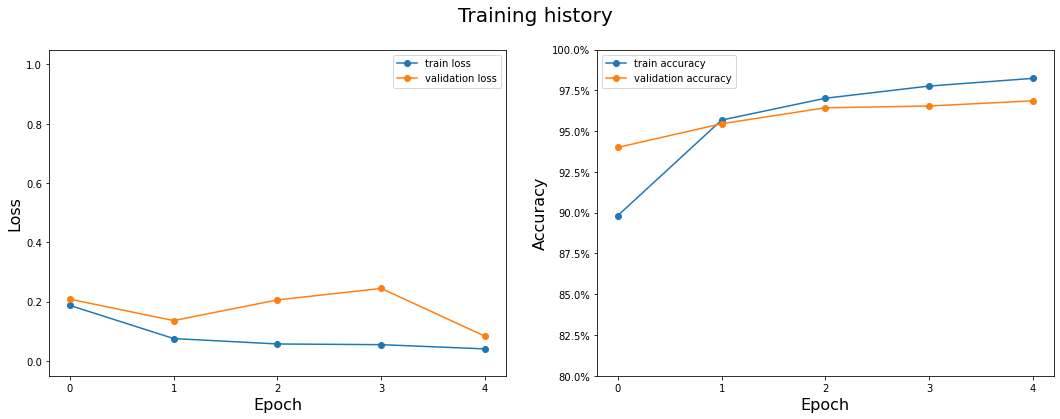

In [5]:
plot_training_history(output_56, ylimitb_lower = 80, ylimitb_upper = 100)

## Training on 28*28 Images

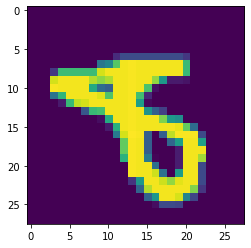

In [6]:
resolution = 28
im_28, _,_ = load_in_data(resolution)
data, _ = next(iter(im_28))

plt.imshow( data[0].permute(1, 2, 0))

In [7]:
resolution = 28

train_28, valid_28, test_28 = load_in_data(resolution)
model_28 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_28 = train_model(train_28,valid_28,model_28,epochs)

Epoch 1 of 5
---------------
loss: 2.296420  [    0/42000]
loss: 0.453357  [12800/42000]
loss: 0.269959  [25600/42000]
loss: 0.186896  [38400/42000]
Train Error:
 Accuracy: 88.0%, Avg loss: 0.000833 

Validation Error: 
 Accuracy: 92.9%, Avg loss: 0.235306 

Epoch 2 of 5
---------------
loss: 0.277599  [    0/42000]
loss: 0.343053  [12800/42000]
loss: 0.162197  [25600/42000]
loss: 0.062138  [38400/42000]
Train Error:
 Accuracy: 94.7%, Avg loss: 0.000470 

Validation Error: 
 Accuracy: 94.4%, Avg loss: 0.171635 

Epoch 3 of 5
---------------
loss: 0.077083  [    0/42000]
loss: 0.083334  [12800/42000]
loss: 0.171017  [25600/42000]
loss: 0.057396  [38400/42000]
Train Error:
 Accuracy: 96.3%, Avg loss: 0.000332 

Validation Error: 
 Accuracy: 95.6%, Avg loss: 0.128074 

Epoch 4 of 5
---------------
loss: 0.196366  [    0/42000]
loss: 0.105411  [12800/42000]
loss: 0.064966  [25600/42000]
loss: 0.109643  [38400/42000]
Train Error:
 Accuracy: 97.2%, Avg loss: 0.000234 

Validation Error: 
 Ac

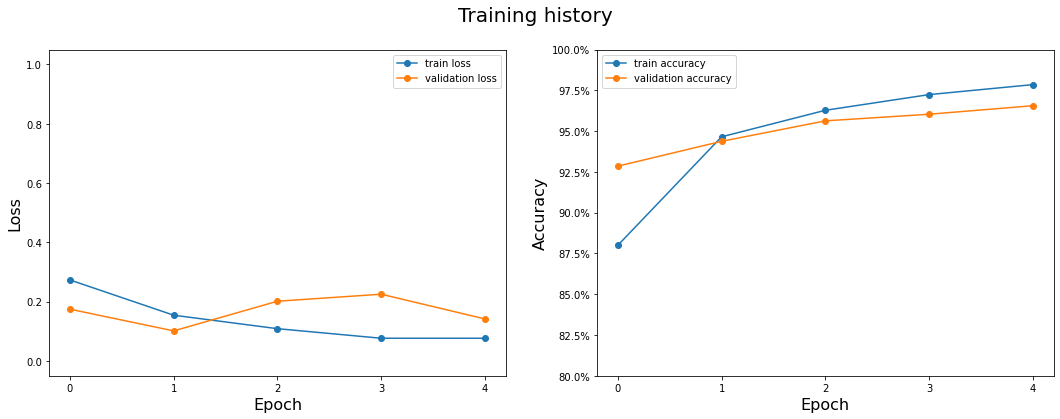

In [8]:
plot_training_history(output_28, ylimitb_lower = 80, ylimitb_upper = 100)

## Training on 14*14 Images

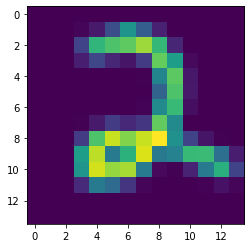

In [15]:
resolution = 14
im_14, _,_ = load_in_data(resolution)
data_14, _ = next(iter(im_14))

plt.imshow( data_14[0].permute(1, 2, 0))

In [13]:
resolution = 14

train_14, valid_14, test_14 = load_in_data(resolution)
model_14 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_14 = train_model(train_14,valid_14,model_14,epochs)

Epoch 1 of 5
---------------
loss: 2.299318  [    0/42000]
loss: 0.584645  [12800/42000]
loss: 0.276249  [25600/42000]
loss: 0.330942  [38400/42000]
Train Error:
 Accuracy: 86.0%, Avg loss: 0.000623 

Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.289431 

Epoch 2 of 5
---------------
loss: 0.261636  [    0/42000]
loss: 0.260390  [12800/42000]
loss: 0.202734  [25600/42000]
loss: 0.204009  [38400/42000]
Train Error:
 Accuracy: 93.3%, Avg loss: 0.000775 

Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.210863 

Epoch 3 of 5
---------------
loss: 0.207601  [    0/42000]
loss: 0.170010  [12800/42000]
loss: 0.147755  [25600/42000]
loss: 0.166791  [38400/42000]
Train Error:
 Accuracy: 94.9%, Avg loss: 0.000595 

Validation Error: 
 Accuracy: 94.5%, Avg loss: 0.170644 

Epoch 4 of 5
---------------
loss: 0.135899  [    0/42000]
loss: 0.057702  [12800/42000]
loss: 0.164705  [25600/42000]
loss: 0.092918  [38400/42000]
Train Error:
 Accuracy: 95.8%, Avg loss: 0.000226 

Validation Error: 
 Ac

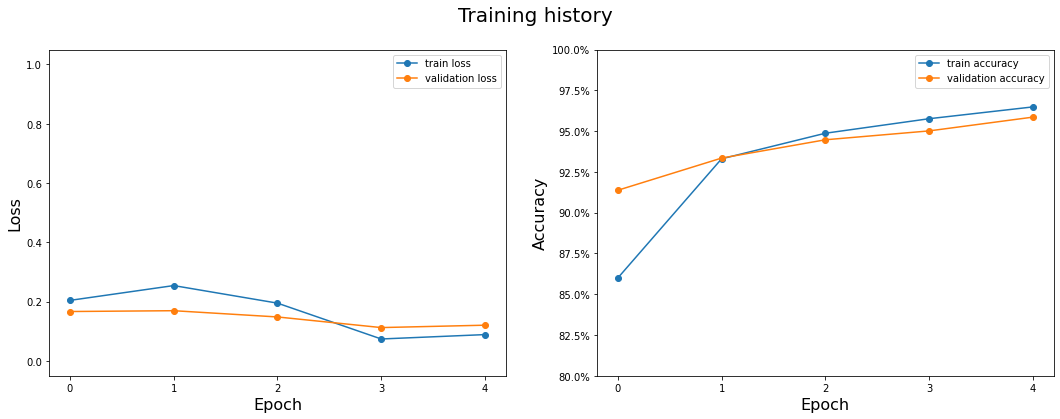

In [14]:
plot_training_history(output_14, ylimitb_lower = 80, ylimitb_upper = 100)

# Training on 7*7 images

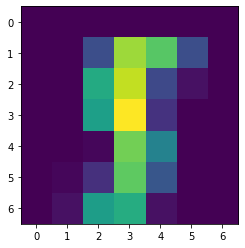

In [16]:
resolution = 7
im_7, _,_ = load_in_data(resolution)
data_7, _ = next(iter(im_7))

plt.imshow( data_7[0].permute(1, 2, 0))

In [17]:
resolution = 7

train_7, valid_7, test_7 = load_in_data(resolution)
model_7 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_7 = train_model(train_7,valid_7,model_7,epochs)

Epoch 1 of 5
---------------
loss: 2.302593  [    0/42000]
loss: 0.673267  [12800/42000]
loss: 0.413568  [25600/42000]
loss: 0.423135  [38400/42000]
Train Error:
 Accuracy: 81.2%, Avg loss: 0.001114 

Validation Error: 
 Accuracy: 88.1%, Avg loss: 0.381273 

Epoch 2 of 5
---------------
loss: 0.391128  [    0/42000]
loss: 0.395294  [12800/42000]
loss: 0.265812  [25600/42000]
loss: 0.303730  [38400/42000]
Train Error:
 Accuracy: 90.5%, Avg loss: 0.001042 

Validation Error: 
 Accuracy: 90.3%, Avg loss: 0.305094 

Epoch 3 of 5
---------------
loss: 0.268388  [    0/42000]
loss: 0.235224  [12800/42000]
loss: 0.232529  [25600/42000]
loss: 0.220770  [38400/42000]
Train Error:
 Accuracy: 92.3%, Avg loss: 0.000645 

Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.246814 

Epoch 4 of 5
---------------
loss: 0.230293  [    0/42000]
loss: 0.293859  [12800/42000]
loss: 0.228362  [25600/42000]
loss: 0.246826  [38400/42000]
Train Error:
 Accuracy: 93.3%, Avg loss: 0.000481 

Validation Error: 
 Ac

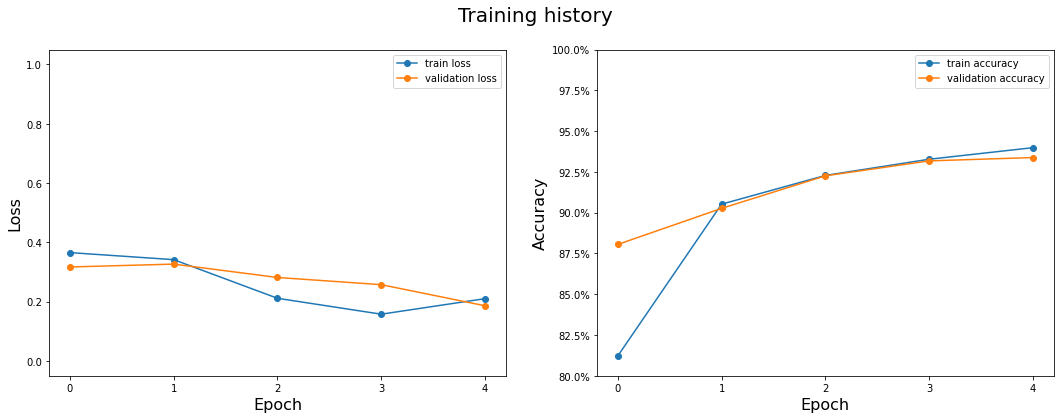

In [18]:
plot_training_history(output_7, ylimitb_lower = 80, ylimitb_upper = 100)

# Increasing Epochs

In [19]:
epochs = 20

In [20]:
resolution = 56

train_56, valid_56, test_56 = load_in_data(resolution)
model_56 = Ann_Net(resolution, num_hidden,num_outputs).to(device)
  
output_56a = train_model(train_56,valid_56, model_56,epochs)

Epoch 1 of 20
---------------
loss: 2.299137  [    0/42000]
loss: 0.297236  [12800/42000]
loss: 0.194803  [25600/42000]
loss: 0.226744  [38400/42000]
Train Error:
 Accuracy: 89.9%, Avg loss: 0.000825 

Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.197934 

Epoch 2 of 20
---------------
loss: 0.171767  [    0/42000]
loss: 0.157350  [12800/42000]
loss: 0.072897  [25600/42000]
loss: 0.081128  [38400/42000]
Train Error:
 Accuracy: 95.6%, Avg loss: 0.000468 

Validation Error: 
 Accuracy: 95.5%, Avg loss: 0.136013 

Epoch 3 of 20
---------------
loss: 0.077073  [    0/42000]
loss: 0.105692  [12800/42000]
loss: 0.230511  [25600/42000]
loss: 0.113504  [38400/42000]
Train Error:
 Accuracy: 96.9%, Avg loss: 0.000130 

Validation Error: 
 Accuracy: 96.5%, Avg loss: 0.102818 

Epoch 4 of 20
---------------
loss: 0.143070  [    0/42000]
loss: 0.075530  [12800/42000]
loss: 0.138902  [25600/42000]
loss: 0.057448  [38400/42000]
Train Error:
 Accuracy: 97.8%, Avg loss: 0.000151 

Validation Error: 

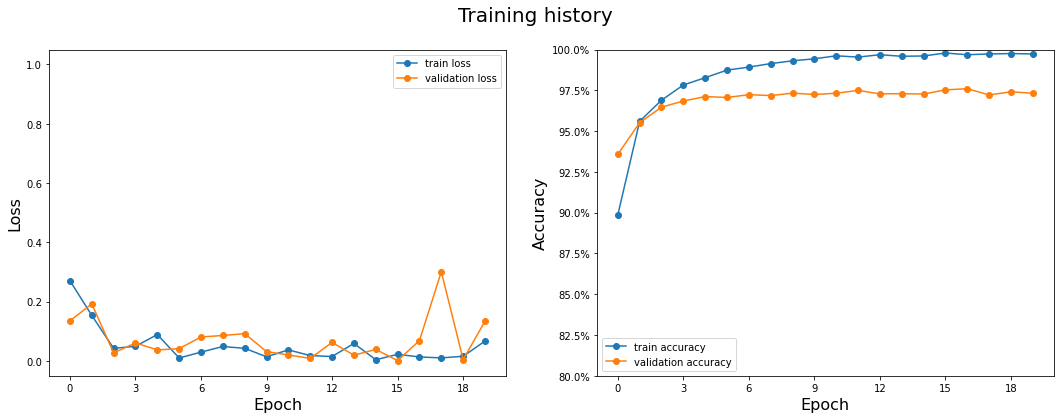

In [21]:
plot_training_history(output_56a, ylimitb_lower = 80, ylimitb_upper = 100)

## Training on 28*28 Images

In [22]:
resolution = 28

train_28, valid_28, test_28 = load_in_data(resolution)
model_28 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_28a = train_model(train_28,valid_28,model_28,epochs)

Epoch 1 of 20
---------------
loss: 2.298729  [    0/42000]
loss: 0.405877  [12800/42000]
loss: 0.350603  [25600/42000]
loss: 0.232647  [38400/42000]
Train Error:
 Accuracy: 87.8%, Avg loss: 0.000376 

Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.232463 

Epoch 2 of 20
---------------
loss: 0.161866  [    0/42000]
loss: 0.327827  [12800/42000]
loss: 0.120839  [25600/42000]
loss: 0.074164  [38400/42000]
Train Error:
 Accuracy: 94.7%, Avg loss: 0.000708 

Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.175266 

Epoch 3 of 20
---------------
loss: 0.164387  [    0/42000]
loss: 0.071466  [12800/42000]
loss: 0.069465  [25600/42000]
loss: 0.182193  [38400/42000]
Train Error:
 Accuracy: 96.3%, Avg loss: 0.000260 

Validation Error: 
 Accuracy: 95.7%, Avg loss: 0.132293 

Epoch 4 of 20
---------------
loss: 0.136031  [    0/42000]
loss: 0.082863  [12800/42000]
loss: 0.107426  [25600/42000]
loss: 0.117450  [38400/42000]
Train Error:
 Accuracy: 97.4%, Avg loss: 0.000315 

Validation Error: 

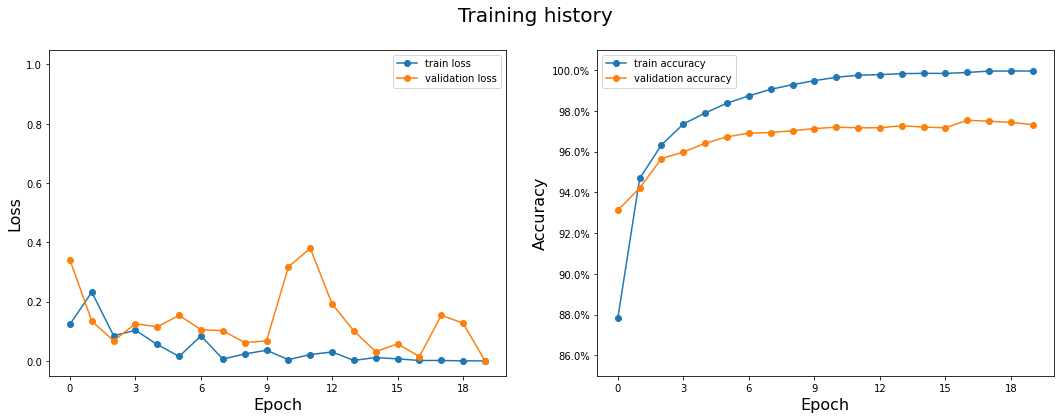

In [31]:
plot_training_history(output_28a, ylimitb_lower = 85, ylimitb_upper = 101)

## Training on 14*14 Images

In [24]:
resolution = 14

train_14, valid_14, test_14 = load_in_data(resolution)
model_14 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_14a = train_model(train_14,valid_14,model_14,epochs)

Epoch 1 of 20
---------------
loss: 2.306528  [    0/42000]
loss: 0.458826  [12800/42000]
loss: 0.337060  [25600/42000]
loss: 0.244400  [38400/42000]
Train Error:
 Accuracy: 86.1%, Avg loss: 0.001025 

Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.282782 

Epoch 2 of 20
---------------
loss: 0.253060  [    0/42000]
loss: 0.151583  [12800/42000]
loss: 0.111056  [25600/42000]
loss: 0.158151  [38400/42000]
Train Error:
 Accuracy: 93.1%, Avg loss: 0.000480 

Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.215057 

Epoch 3 of 20
---------------
loss: 0.119320  [    0/42000]
loss: 0.157560  [12800/42000]
loss: 0.222839  [25600/42000]
loss: 0.159167  [38400/42000]
Train Error:
 Accuracy: 94.7%, Avg loss: 0.000662 

Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.177937 

Epoch 4 of 20
---------------
loss: 0.199104  [    0/42000]
loss: 0.103767  [12800/42000]
loss: 0.203929  [25600/42000]
loss: 0.118043  [38400/42000]
Train Error:
 Accuracy: 95.8%, Avg loss: 0.000371 

Validation Error: 

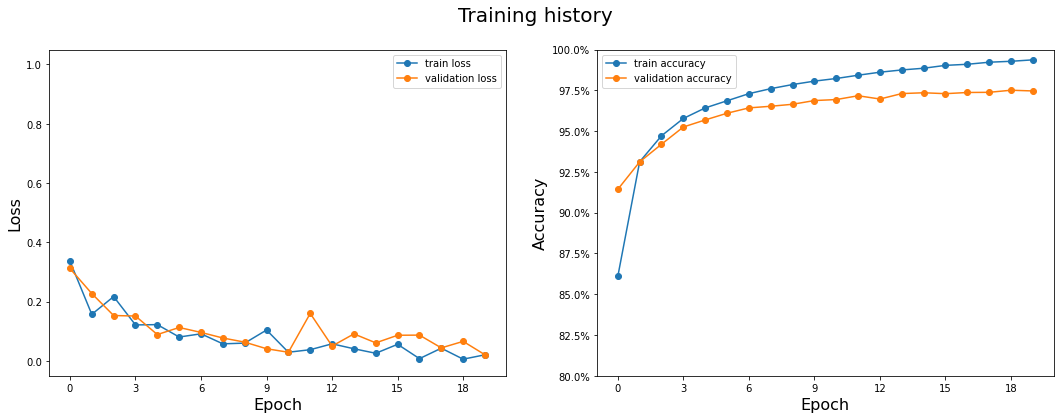

In [25]:
plot_training_history(output_14a, ylimitb_lower = 80, ylimitb_upper = 100)

# Training on 7*7 images

In [26]:
resolution = 7

train_7, valid_7, test_7 = load_in_data(resolution)
model_7 = Ann_Net(resolution, num_hidden,num_outputs).to(device)

output_7a = train_model(train_7,valid_7,model_7,epochs)

Epoch 1 of 20
---------------
loss: 2.305741  [    0/42000]
loss: 0.898482  [12800/42000]
loss: 0.463219  [25600/42000]
loss: 0.283553  [38400/42000]
Train Error:
 Accuracy: 80.8%, Avg loss: 0.001304 

Validation Error: 
 Accuracy: 88.4%, Avg loss: 0.373663 

Epoch 2 of 20
---------------
loss: 0.352628  [    0/42000]
loss: 0.211660  [12800/42000]
loss: 0.315667  [25600/42000]
loss: 0.245790  [38400/42000]
Train Error:
 Accuracy: 90.5%, Avg loss: 0.000744 

Validation Error: 
 Accuracy: 90.7%, Avg loss: 0.298431 

Epoch 3 of 20
---------------
loss: 0.314776  [    0/42000]
loss: 0.175806  [12800/42000]
loss: 0.390781  [25600/42000]
loss: 0.176201  [38400/42000]
Train Error:
 Accuracy: 92.3%, Avg loss: 0.000496 

Validation Error: 
 Accuracy: 92.4%, Avg loss: 0.242802 

Epoch 4 of 20
---------------
loss: 0.159070  [    0/42000]
loss: 0.286638  [12800/42000]
loss: 0.089646  [25600/42000]
loss: 0.197923  [38400/42000]
Train Error:
 Accuracy: 93.3%, Avg loss: 0.000746 

Validation Error: 

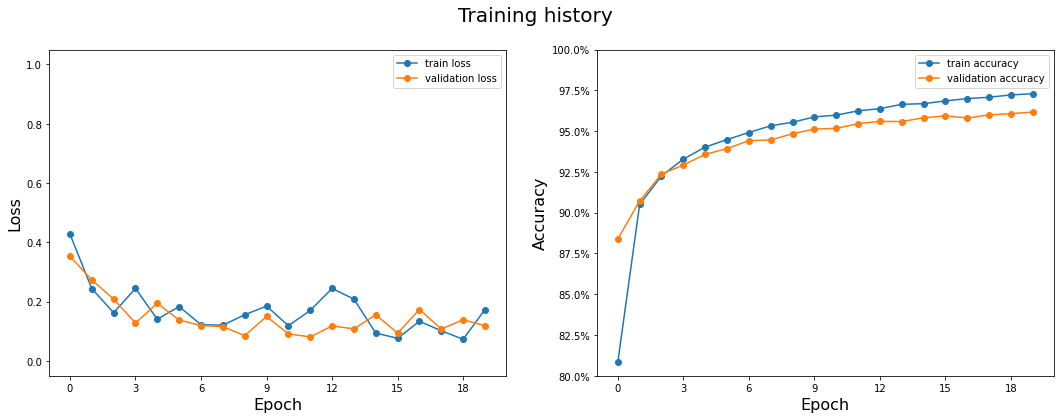

In [27]:
plot_training_history(output_7a, ylimitb_lower = 80, ylimitb_upper = 100)

In [28]:
output_7a.keys()

dict_keys(['train_minibatch_loss', 'train_loss', 'train_accuracy', 'valid_minibatch_loss', 'valid_loss', 'valid_accuracy'])

# Storing all results in DF. 

In [34]:
all_output_nums = ['56','28','14','7']
all_outputs = []
all_outputs_a = []
for entry in all_output_nums:
    string = 'output_' + entry
    string_a = 'output_' + entry + 'a'
    all_outputs.append(string)
    all_outputs_a.append(string_a)

final_output_list = all_outputs + all_outputs_a

In [35]:
results_df = pd.DataFrame(index = [ 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

for output in final_output_list:
    results = store_best_results(locals()[output])
    column_name = output.replace('output_','ANN')
    results_df[column_name] = results

In [36]:
results_df.to_csv('model_results.csv')

In [33]:
results_df = pd.read_csv('model_results.csv',index_col = 0)